Flowers Recognition dataset https://www.kaggle.com/datasets/alxmamaev/flowers-recognition will be used. In this dataset, there are 5 classes: daisy, dandelion, rose, sunflower, and tulip. Images belonging to a specific class are collected in the corresponding folder name


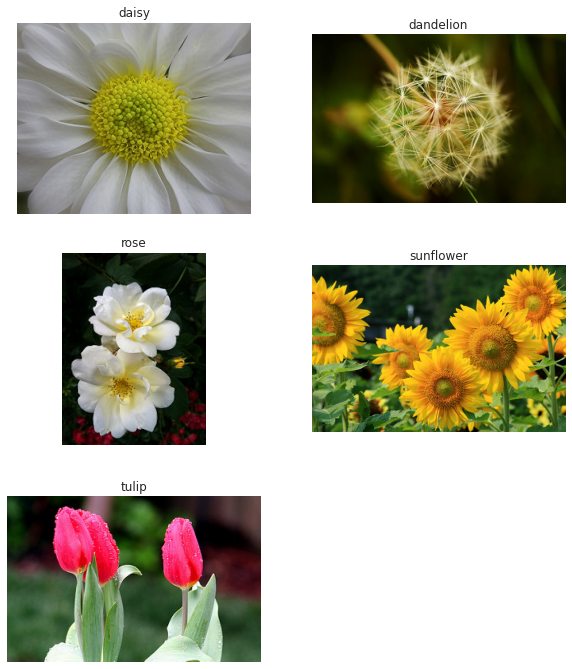

## Step 1: Import libraries

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, losses, optimizers
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

## Step 2: Add noise to X train and Build Dataset

In [2]:
import os
path = os.getcwd()
data_path = os.path.join(path, 'flowers/')

image_paths = []

for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    for img in os.listdir(folder_path):
        image_paths.append(os.path.join(folder_path, img))

In [3]:
image_filenames = tf.constant(image_paths)
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, image_filenames))

In [4]:
def process_path(x_path, y_path):
    x_path = y_path
    img = tf.io.read_file(x_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img, img

def preprocess(x, y):
    x = tf.image.resize(x, (128, 128), method='nearest')
    x = x + 0.2 * tf.random.normal(shape=x.shape)
    x = tf.clip_by_value(x, clip_value_min=0., clip_value_max=1.)

    y = tf.image.resize(y, (128, 128), method='nearest')

    return x, y

In [5]:
image_ds = dataset.map(process_path).map(preprocess)

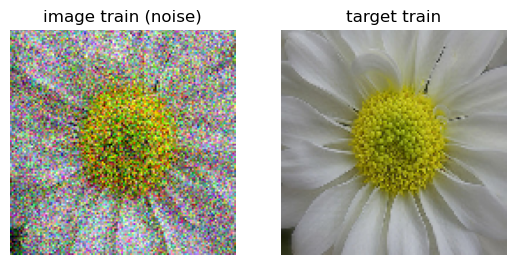

In [6]:
for image, target in image_ds.take(1):
    plt.subplot(1, 2, 1);plt.title('image train (noise)');plt.imshow(image);plt.axis('off')
    plt.subplot(1, 2, 2);plt.title('target train');plt.imshow(target);plt.axis('off')
    plt.show()

## Step 3: Build Convolutional Autoencoder

In [7]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
                    layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
                    layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)
                    ])
        self.decoder = tf.keras.Sequential([
                    layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
                    layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
                    layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')
                    ])
        
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [8]:
def create_model(input_shape):
    model = Denoise()
    model.build(input_shape=(None,)+input_shape)
    model.summary()
    return model

In [9]:
autoencoder = create_model(input_shape=(128, 128, 3))

Model: "denoise"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 32)        20256     
                                                                 
 sequential_1 (Sequential)   (None, 128, 128, 3)       29475     
                                                                 
Total params: 49,731
Trainable params: 49,731
Non-trainable params: 0
_________________________________________________________________


In [10]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
Total params: 20,256
Trainable params: 20,256
Non-trainable params: 0
_________________________________________________________________


In [11]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 64, 64, 32)       9248      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 128, 128, 64)     18496     
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 3)       1731      
                                                                 
Total params: 29,475
Trainable params: 29,475
Non-trainable params: 0
_________________________________________________________________


In [12]:
train_size = int(0.9 * len(image_ds))

train_dataset = image_ds.take(train_size).shuffle(64).batch(8).prefetch(1)
val_dataset = image_ds.skip(train_size).shuffle(64).batch(8).prefetch(1)

In [13]:
autoencoder.compile(optimizer=optimizers.Adam(), 
                    loss=losses.MeanSquaredError())

history = autoencoder.fit(train_dataset, validation_data=val_dataset, epochs=50)

Epoch 1/50
486/486 [==============================] - 29s 44ms/step - loss: 0.0186 - val_loss: 0.0121
Epoch 2/50
486/486 [==============================] - 20s 41ms/step - loss: 0.0089 - val_loss: 0.0108
Epoch 3/50
486/486 [==============================] - 20s 41ms/step - loss: 0.0079 - val_loss: 0.0100
Epoch 4/50
486/486 [==============================] - 20s 41ms/step - loss: 0.0075 - val_loss: 0.0092
Epoch 5/50
486/486 [==============================] - 20s 41ms/step - loss: 0.0071 - val_loss: 0.0087
Epoch 6/50
486/486 [==============================] - 21s 42ms/step - loss: 0.0068 - val_loss: 0.0084
Epoch 7/50
486/486 [==============================] - 21s 42ms/step - loss: 0.0066 - val_loss: 0.0083
Epoch 8/50
486/486 [==============================] - 20s 41ms/step - loss: 0.0064 - val_loss: 0.0080
Epoch 9/50
486/486 [==============================] - 20s 41ms/step - loss: 0.0062 - val_loss: 0.0079
Epoch 10/50
486/486 [==============================] - 20s 41ms/step - loss: 0.006

In [14]:
test_image = image_ds.skip(train_size)

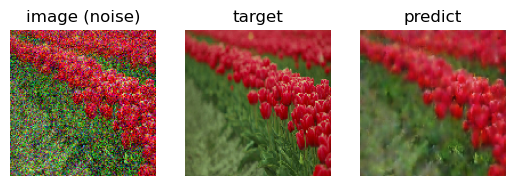

In [15]:
for image, target in test_image.take(1):
    predict = autoencoder(tf.expand_dims(image, axis=0))
    plt.subplot(1, 3, 1);plt.title('image (noise)');plt.imshow(image);plt.axis('off')
    plt.subplot(1, 3, 2);plt.title('target');plt.imshow(target);plt.axis('off')
    plt.subplot(1, 3, 3);plt.title('predict');plt.imshow(tf.reshape(predict, (128, 128, 3)));plt.axis('off')

    plt.show()